# Bidirectional GRU


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit

# from sklearn.preprocessing import OneHotEncoder

# For the manual cross validation
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.set_floatx('float32')

EPOCHS=50
SPLITS=3
K=3
EMBED_DIMEN=16

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def build_model(maxlen,dimen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    rnn = keras.models.Sequential()
    embed_layer = keras.layers.Embedding(
        vocabulary_size,EMBED_DIMEN,input_length=maxlen);
    rnn1_layer = keras.layers.Bidirectional(
        keras.layers.GRU(16, return_sequences=True, 
            input_shape=[maxlen,dimen]))
    rnn2_layer = keras.layers.Bidirectional(
        keras.layers.GRU(16, return_sequences=True))
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = keras.layers.Dense(16,activation=act,dtype=dt)
    dense2_layer = keras.layers.Dense(16,activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [5]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn2=build_model(maxlen,dimen)

        print("FIT")
        # this is complaining about string to float
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


In [6]:
def make_kmers(MINLEN,MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
print("Load data from files.")
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


## Len 200-1Kb


Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[12 46 54 ...  0  0  0]
 [ 9 36 14 ...  0  0  0]
 [34  7 28 ...  0  0  0]
 ...
 [37 19  9 ...  0  0  0]
 [57 36 15 ...  0  0  0]
 [33  3 12 ...  0  0  0]]
Compile the model
COMPILE
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          1040      
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 32)          3264      
_________________________________________________________________
bidirectional_1 

222/222 [==============================] - 228s 1s/step - loss: 0.3607 - accuracy: 0.8383 - val_loss: 0.3996 - val_accuracy: 0.8142
Epoch 46/50
222/222 [==============================] - 227s 1s/step - loss: 0.3616 - accuracy: 0.8394 - val_loss: 0.4046 - val_accuracy: 0.8143
Epoch 47/50
222/222 [==============================] - 226s 1s/step - loss: 0.3593 - accuracy: 0.8376 - val_loss: 0.4018 - val_accuracy: 0.8153
Epoch 48/50
222/222 [==============================] - 230s 1s/step - loss: 0.3565 - accuracy: 0.8369 - val_loss: 0.4026 - val_accuracy: 0.8207
Epoch 49/50
222/222 [==============================] - 227s 1s/step - loss: 0.3560 - accuracy: 0.8384 - val_loss: 0.3974 - val_accuracy: 0.8183
Epoch 50/50
222/222 [==============================] - 230s 1s/step - loss: 0.3572 - accuracy: 0.8393 - val_loss: 0.3992 - val_accuracy: 0.8206
Fold 1, 50 epochs


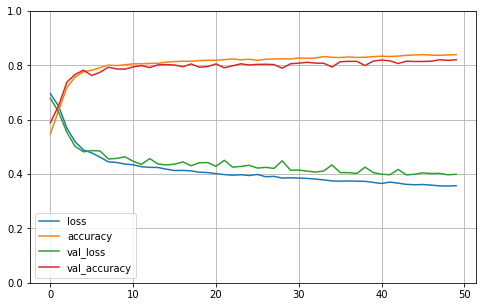

accuracy: 82.06%
BUILD MODEL
COMPILE
FIT
Epoch 1/50
222/222 [==============================] - 236s 1s/step - loss: 0.6805 - accuracy: 0.5723 - val_loss: 0.6643 - val_accuracy: 0.6017
Epoch 2/50
222/222 [==============================] - 229s 1s/step - loss: 0.6448 - accuracy: 0.6372 - val_loss: 0.6157 - val_accuracy: 0.6839
Epoch 3/50
222/222 [==============================] - 227s 1s/step - loss: 0.6023 - accuracy: 0.6941 - val_loss: 0.5741 - val_accuracy: 0.7187
Epoch 4/50
222/222 [==============================] - 227s 1s/step - loss: 0.5371 - accuracy: 0.7441 - val_loss: 0.5117 - val_accuracy: 0.7624
Epoch 5/50
222/222 [==============================] - 226s 1s/step - loss: 0.4808 - accuracy: 0.7842 - val_loss: 0.4775 - val_accuracy: 0.7830
Epoch 6/50
222/222 [==============================] - 226s 1s/step - loss: 0.4594 - accuracy: 0.7919 - val_loss: 0.4621 - val_accuracy: 0.7824
Epoch 7/50
222/222 [==============================] - 227s 1s/step - loss: 0.4409 - accuracy: 0.8017 

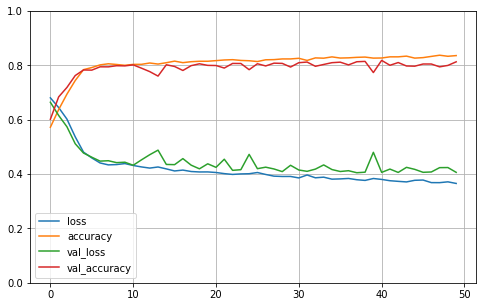

accuracy: 81.31%
BUILD MODEL
COMPILE
FIT
Epoch 1/50
222/222 [==============================] - 229s 1s/step - loss: 0.6723 - accuracy: 0.5872 - val_loss: 0.6842 - val_accuracy: 0.6047
Epoch 2/50
222/222 [==============================] - 219s 988ms/step - loss: 0.6461 - accuracy: 0.6429 - val_loss: 0.6360 - val_accuracy: 0.6604
Epoch 3/50
222/222 [==============================] - 219s 985ms/step - loss: 0.6276 - accuracy: 0.6595 - val_loss: 0.5832 - val_accuracy: 0.7271
Epoch 4/50
222/222 [==============================] - 218s 980ms/step - loss: 0.5589 - accuracy: 0.7315 - val_loss: 0.5110 - val_accuracy: 0.7698
Epoch 5/50
222/222 [==============================] - 219s 987ms/step - loss: 0.5107 - accuracy: 0.7601 - val_loss: 0.4866 - val_accuracy: 0.7791
Epoch 6/50
222/222 [==============================] - 218s 982ms/step - loss: 0.4746 - accuracy: 0.7841 - val_loss: 0.4891 - val_accuracy: 0.7688
Epoch 7/50
222/222 [==============================] - 217s 980ms/step - loss: 0.4699 -

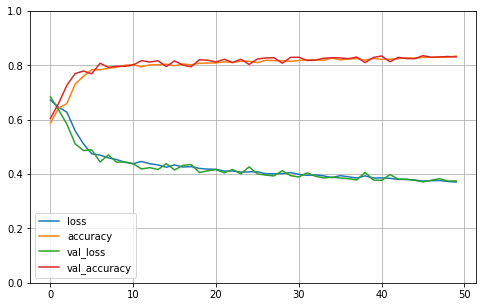

accuracy: 83.08%

Validation core mean 82.15% (+/- 0.73%)


In [8]:
MINLEN=200
MAXLEN=1000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

## Len 1K-2Kb

Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(3368, 1)
sequence    GGCGGGGTCGACTGACGGTAACGGGGCAGAGAGGCTGTTCGCAGAG...
Name: 12641, dtype: object
1338
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[42 39 27 ...  0  0  0]
 [57 34  5 ...  0  0  0]
 [27 44 47 ...  0  0  0]
 ...
 [44 47 57 ...  0  0  0]
 [10 37 20 ...  0  0  0]
 [47 60 48 ...  0  0  0]]
Compile the model
COMPILE
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2000, 16)          1040      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 2000, 32)          3264      
_________________________________________________________________
bidirectiona

85/85 [==============================] - 192s 2s/step - loss: 0.3654 - accuracy: 0.8447 - val_loss: 0.3719 - val_accuracy: 0.8373
Epoch 47/50
85/85 [==============================] - 192s 2s/step - loss: 0.3675 - accuracy: 0.8462 - val_loss: 0.3848 - val_accuracy: 0.8311
Epoch 48/50
85/85 [==============================] - 192s 2s/step - loss: 0.3696 - accuracy: 0.8441 - val_loss: 0.3919 - val_accuracy: 0.8148
Epoch 49/50
85/85 [==============================] - 200s 2s/step - loss: 0.3728 - accuracy: 0.8441 - val_loss: 0.3920 - val_accuracy: 0.8283
Epoch 50/50
85/85 [==============================] - 199s 2s/step - loss: 0.3712 - accuracy: 0.8412 - val_loss: 0.3957 - val_accuracy: 0.8110
Fold 1, 50 epochs


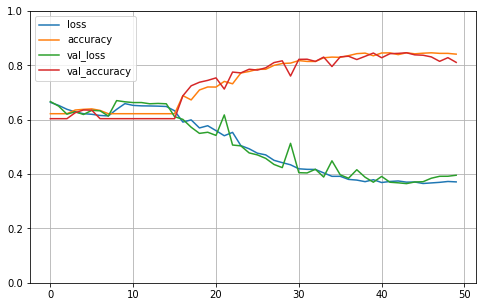

accuracy: 81.10%
BUILD MODEL
COMPILE
FIT
Epoch 1/50
85/85 [==============================] - 214s 3s/step - loss: 0.6675 - accuracy: 0.6166 - val_loss: 0.6601 - val_accuracy: 0.6261
Epoch 2/50
85/85 [==============================] - 200s 2s/step - loss: 0.6582 - accuracy: 0.6166 - val_loss: 0.6487 - val_accuracy: 0.6261
Epoch 3/50
85/85 [==============================] - 201s 2s/step - loss: 0.6390 - accuracy: 0.6166 - val_loss: 0.6368 - val_accuracy: 0.6261
Epoch 4/50
85/85 [==============================] - 196s 2s/step - loss: 0.6406 - accuracy: 0.6264 - val_loss: 0.6269 - val_accuracy: 0.6543
Epoch 5/50
85/85 [==============================] - 193s 2s/step - loss: 0.6270 - accuracy: 0.6188 - val_loss: 0.6120 - val_accuracy: 0.6375
Epoch 6/50
85/85 [==============================] - 194s 2s/step - loss: 0.6461 - accuracy: 0.5985 - val_loss: 0.6575 - val_accuracy: 0.6261
Epoch 7/50
85/85 [==============================] - 193s 2s/step - loss: 0.6490 - accuracy: 0.6166 - val_loss: 0.

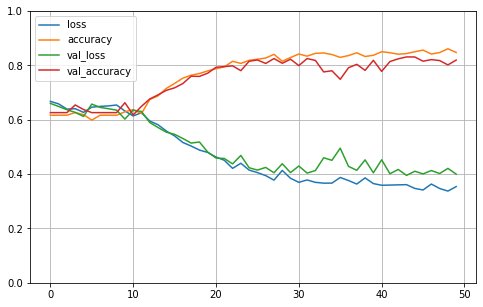

accuracy: 81.94%
BUILD MODEL
COMPILE
FIT
Epoch 1/50
85/85 [==============================] - 214s 3s/step - loss: 0.6669 - accuracy: 0.6158 - val_loss: 0.6590 - val_accuracy: 0.6291
Epoch 2/50
85/85 [==============================] - 214s 3s/step - loss: 0.6581 - accuracy: 0.6158 - val_loss: 0.6495 - val_accuracy: 0.6291
Epoch 3/50
85/85 [==============================] - 214s 3s/step - loss: 0.6421 - accuracy: 0.6158 - val_loss: 0.6324 - val_accuracy: 0.6291
Epoch 4/50
85/85 [==============================] - 210s 2s/step - loss: 0.6440 - accuracy: 0.6269 - val_loss: 0.6321 - val_accuracy: 0.6159
Epoch 5/50
85/85 [==============================] - 206s 2s/step - loss: 0.6357 - accuracy: 0.6161 - val_loss: 0.6170 - val_accuracy: 0.6291
Epoch 6/50
85/85 [==============================] - 206s 2s/step - loss: 0.6423 - accuracy: 0.6158 - val_loss: 0.6276 - val_accuracy: 0.6291
Epoch 7/50
85/85 [==============================] - 200s 2s/step - loss: 0.6320 - accuracy: 0.6180 - val_loss: 0.

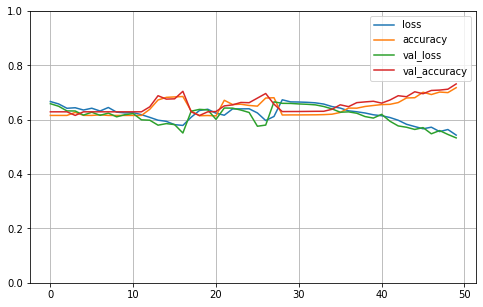

accuracy: 73.17%

Validation core mean 78.74% (+/- 3.95%)


In [9]:
MINLEN=1000
MAXLEN=2000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

## Len 2K-3Kb

Working on full training set, slice by sequence length.
Slice size range [2000 - 3000)
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(1351, 1)
sequence    GTCATTCTAGCTGCCTGCTGCCTCCGCAGCGTCCCCCCAGCTCTCC...
Name: 19713, dtype: object
2039
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[46 53 20 ...  0  0  0]
 [ 3 10 37 ...  0  0  0]
 [12 48 62 ...  0  0  0]
 ...
 [13 49  3 ...  0  0  0]
 [39 25 33 ...  0  0  0]
 [ 9 36 15 ...  0  0  0]]
Compile the model
COMPILE
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 3000, 16)          1040      
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 3000, 32)          3264      
_________________________________________________________________
bidirectiona

34/34 [==============================] - 136s 4s/step - loss: 0.5448 - accuracy: 0.7207 - val_loss: 0.5544 - val_accuracy: 0.7163
Epoch 47/50
34/34 [==============================] - 136s 4s/step - loss: 0.5246 - accuracy: 0.7365 - val_loss: 0.5480 - val_accuracy: 0.6931
Epoch 48/50
34/34 [==============================] - 136s 4s/step - loss: 0.5397 - accuracy: 0.7053 - val_loss: 0.5831 - val_accuracy: 0.6611
Epoch 49/50
34/34 [==============================] - 137s 4s/step - loss: 0.5305 - accuracy: 0.7120 - val_loss: 0.5510 - val_accuracy: 0.6886
Epoch 50/50
34/34 [==============================] - 136s 4s/step - loss: 0.5219 - accuracy: 0.7204 - val_loss: 0.5564 - val_accuracy: 0.7119
Fold 1, 50 epochs


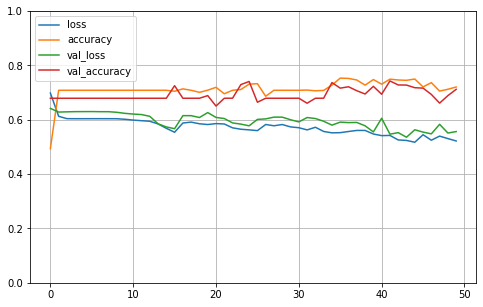

accuracy: 71.19%
BUILD MODEL
COMPILE
FIT
Epoch 1/50
34/34 [==============================] - 144s 4s/step - loss: 0.6243 - accuracy: 0.7000 - val_loss: 0.6002 - val_accuracy: 0.7122
Epoch 2/50
34/34 [==============================] - 137s 4s/step - loss: 0.6113 - accuracy: 0.7000 - val_loss: 0.5997 - val_accuracy: 0.7122
Epoch 3/50
34/34 [==============================] - 139s 4s/step - loss: 0.6102 - accuracy: 0.7000 - val_loss: 0.5984 - val_accuracy: 0.7122
Epoch 4/50
34/34 [==============================] - 136s 4s/step - loss: 0.6070 - accuracy: 0.7000 - val_loss: 0.5970 - val_accuracy: 0.7122
Epoch 5/50
34/34 [==============================] - 136s 4s/step - loss: 0.6024 - accuracy: 0.7000 - val_loss: 0.5953 - val_accuracy: 0.7122
Epoch 6/50
34/34 [==============================] - 133s 4s/step - loss: 0.6002 - accuracy: 0.7000 - val_loss: 0.5973 - val_accuracy: 0.7122
Epoch 7/50
34/34 [==============================] - 133s 4s/step - loss: 0.5988 - accuracy: 0.7000 - val_loss: 0.

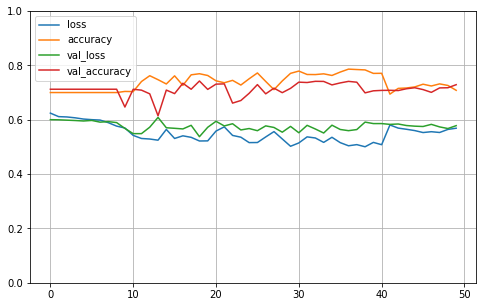

accuracy: 72.89%
BUILD MODEL
COMPILE
FIT
Epoch 1/50
34/34 [==============================] - 149s 4s/step - loss: 0.6916 - accuracy: 0.5100 - val_loss: 0.6333 - val_accuracy: 0.6900
Epoch 2/50
34/34 [==============================] - 141s 4s/step - loss: 0.6118 - accuracy: 0.7056 - val_loss: 0.6190 - val_accuracy: 0.6900
Epoch 3/50
34/34 [==============================] - 140s 4s/step - loss: 0.6062 - accuracy: 0.7056 - val_loss: 0.6197 - val_accuracy: 0.6900
Epoch 4/50
34/34 [==============================] - 140s 4s/step - loss: 0.6059 - accuracy: 0.7056 - val_loss: 0.6189 - val_accuracy: 0.6900
Epoch 5/50
34/34 [==============================] - 138s 4s/step - loss: 0.6056 - accuracy: 0.7056 - val_loss: 0.6182 - val_accuracy: 0.6900
Epoch 6/50
34/34 [==============================] - 142s 4s/step - loss: 0.6046 - accuracy: 0.7056 - val_loss: 0.6149 - val_accuracy: 0.6900
Epoch 7/50
34/34 [==============================] - 136s 4s/step - loss: 0.6022 - accuracy: 0.7056 - val_loss: 0.

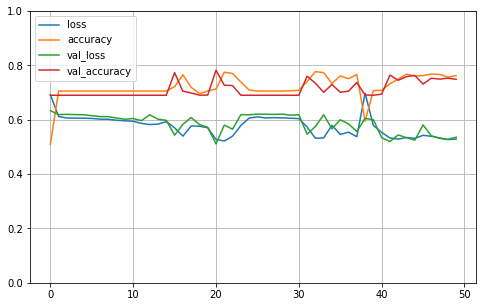

accuracy: 74.88%

Validation core mean 72.99% (+/- 1.51%)


In [10]:
MINLEN=2000
MAXLEN=3000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)